# Modèles Support Vector Machine (SVM) pour classification défaut de crédit

Ce notebook implémente les trois types de SVM pour la classification
1. **C-Support Vector Classification (C-SVC)** - SVM standard avec le paramètre C
3. **Linear SVM** - SVM Linéaire
4. **Non-linear SVM** - SVM avec l'astuce kernel (RBF kernel)
Each model will be trained, evaluated, and compared.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Contexte
1. Le dataset étudié est déséquilibré où 88% de variable cible et de classe 0 l'autre est de classe 1 où notre intérêt réside.
2. Dans un premier temps on va travailler uniquement avec les modèles SVM sans technique pour addresser le problème de déséquilibre de dataset

# Librairies imports

In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

# SVM models
from cuml.svm import SVC as cuSVC
import time
import cupy as cp
import cudf
from imblearn.over_sampling import SMOTE


# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

# Utilities
import time
import pickle
from imblearn.under_sampling import RandomUnderSampler


# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


# Chargement de données

In [3]:
# Load the standardized dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_non_standarise.csv', index_col=0)

print("Dataset Shape:", data.shape)
print("\n" + "="*50)
print("First few rows:")
print(data.head())
print("\n" + "="*50)
print("Dataset Info:")
print(data.info())

Dataset Shape: (255347, 8)

First few rows:
     Income  LoanAmount  MonthsEmployed  InterestRate  Default  Risk_Score  \
Age                                                                          
56    85994       50587              80         15.23        0   10.529383   
69    50432      124440              15          4.81        0   20.743125   
46    84208      129188              26         21.17        1   36.067407   
32    31713       44799               0          7.07        0  226.240000   
60    20437        9139               8          6.51        0   43.400000   

     Affordability_Index  Employment_Maturity  
Age                                            
56            135.991144             8.407602  
69              6.079025             6.943122  
46             16.947325             7.087574  
32              0.000000             0.000000  
60             17.887965             6.175867  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 255347 entrie

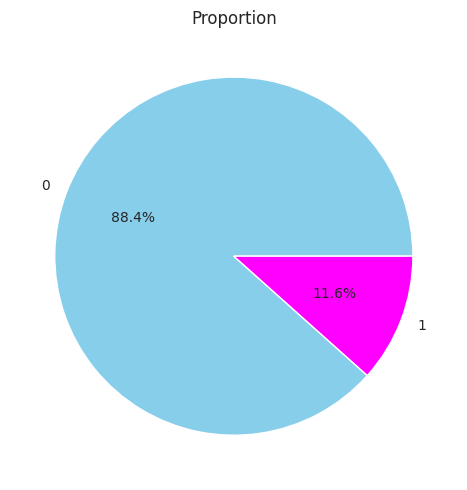

In [4]:
plt.figure(figsize=(5, 5))
data['Default'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                    colors=['skyblue', 'magenta'])
plt.title('Proportion')
plt.ylabel('')  # Remove the ylabel for cleaner appearance
plt.tight_layout()
plt.show()

# Techniques de rééquilibre utilisé:
1. sans technique
2. Ajustement du poids de la classe
3. SMOTE

# Split data and prepare it for GPU calculation

In [5]:
# Separate features and target variable
X = data.drop('Default', axis=1)
y = data['Default']

# Ensure proper data types to avoid attribute errors
X = X.astype('float64')
y = y.astype('int64')
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Convert now GPU
X_train_gpu = cp.asarray(X_train)
y_train_gpu = cp.asarray(y_train)
X_test_gpu = cp.asarray(X_test)

## Model 1: SVM non linéaire Kernal astuce


In [6]:
start_time = time.time()

# Create a cuSVC model
c_svc = cuSVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    probability=True
)

# Fit the model on GPU
c_svc.fit(X_train_gpu, y_train_gpu)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds on GPU!")

✓ Training completed in 75.10 seconds on GPU!


In [7]:
y_pred_gpu = c_svc.predict(X_test_gpu)
y_pred = cp.asnumpy(y_pred_gpu).astype('int64')

# Manual probability via decision function + sigmoid
decision = c_svc.decision_function(X_test_gpu)
decision_np = cp.asnumpy(decision)
y_prob = 1 / (1 + np.exp(-decision_np))

# Keep test labels as numpy
y_test_np = y_test.copy()

print(f"Test predictions shape: {y_pred.shape}")
print(f"Probability range: [{y_prob.min():.4f}, {y_prob.max():.4f}]")

Test predictions shape: (51070,)
Probability range: [0.2688, 0.2690]



 EVALUATION RESULTS: Non linear model

Classification Report:
              precision    recall  f1-score   support

           0     0.8839    1.0000    0.9384     45139
           1     0.0000    0.0000    0.0000      5931

    accuracy                         0.8839     51070
   macro avg     0.4419    0.5000    0.4692     51070
weighted avg     0.7812    0.8839    0.8294     51070


ROC-AUC Score       : 0.5572
PR-AUC (Avg Precision) : 0.1369
Class 1 F1-Score    : 0.0000
Class 1 Recall      : 0.0000
Class 1 Precision   : 0.0000

Confusion Matrix:
[[45139     0]
 [ 5931     0]]


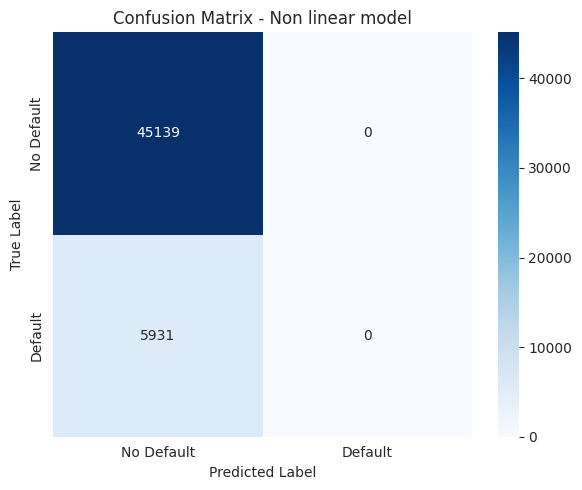

In [8]:
def evaluate_model_final(y_true, y_pred, y_prob, model_name):
    print("\n" + "="*60)
    print(f" EVALUATION RESULTS: {model_name}")
    print("="*60)

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    print(classification_report(y_true, y_pred, digits=4))

    # Key Metrics
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    print(f"\nROC-AUC Score       : {roc_auc:.4f}")
    print(f"PR-AUC (Avg Precision) : {pr_auc:.4f}")

    # Extract F1 for class 1
    f1_class1 = report['1']['f1-score']
    recall_class1 = report['1']['recall']
    precision_class1 = report['1']['precision']
    print(f"Class 1 F1-Score    : {f1_class1:.4f}")
    print(f"Class 1 Recall      : {recall_class1:.4f}")
    print(f"Class 1 Precision   : {precision_class1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
#evaluation
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred,
    y_prob=y_prob,
    model_name="Non linear model"
)

# Modèle 2 : Linear SVM (Linear Kernel)

In [9]:
from cuml.svm import LinearSVC
import time

start_time = time.time()

# Use GPU-accelerated LinearSVC
linear_svm = LinearSVC(
    C=1.0,
    max_iter=1000,        # increase if needed
    tol=1e-3
)

linear_svm.fit(X_train_gpu, y_train_gpu)
training_time = time.time() - start_time

print(f"✓ LinearSVC training completed in {training_time:.4f} seconds on GPU!")

✓ LinearSVC training completed in 0.5727 seconds on GPU!


Test predictions shape: (51070,)
Probability range: [0.0280, 0.4632]

 EVALUATION RESULTS: Linear Kernel

Classification Report:
              precision    recall  f1-score   support

           0     0.8839    1.0000    0.9384     45139
           1     0.0000    0.0000    0.0000      5931

    accuracy                         0.8839     51070
   macro avg     0.4419    0.5000    0.4692     51070
weighted avg     0.7812    0.8839    0.8294     51070


ROC-AUC Score       : 0.6002
PR-AUC (Avg Precision) : 0.1586
Class 1 F1-Score    : 0.0000
Class 1 Recall      : 0.0000
Class 1 Precision   : 0.0000

Confusion Matrix:
[[45139     0]
 [ 5931     0]]


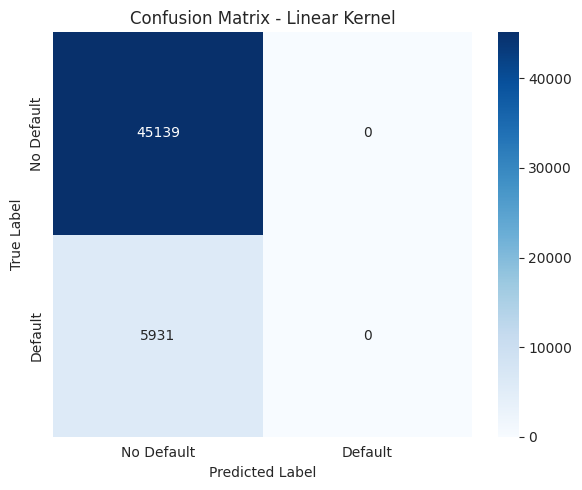

In [10]:
y_pred_gpu_2 = linear_svm.predict(X_test_gpu)
y_pred_2 = cp.asnumpy(y_pred_gpu_2).astype('int64')

# Manual probability via decision function + sigmoid
decision_2 = linear_svm.decision_function(X_test_gpu)
decision_np_2 = cp.asnumpy(decision_2)
y_prob_2 = 1 / (1 + np.exp(-decision_np_2))

# Keep test labels as numpy
y_test_np_2 = y_test.copy()

print(f"Test predictions shape: {y_pred_2.shape}")
print(f"Probability range: [{y_prob_2.min():.4f}, {y_prob_2.max():.4f}]")
evaluate_model_final(
    y_true=y_test_np_2,
    y_pred=y_pred_2,
    y_prob=y_prob_2,
    model_name="Linear Kernel"
)

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features scaled: X_train {X_train.shape} → scaled")

# --------------------------------------------------
# 2. Fit PCA on training data (2 components)
# --------------------------------------------------
pca = PCA(n_components=2, random_state=42)
pca.fit(X_train_scaled)

# Transform test set
X_test_pca = pca.transform(X_test_scaled)

print(f"PCA completed: {X_test_pca.shape[1]} components")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.3f}")
pca_df = pd.DataFrame({
    'PC1': X_test_pca[:, 0],
    'PC2': X_test_pca[:, 1],
    'Default': y_test.astype(int)
})

print(f"PCA DataFrame ready: {pca_df.shape}")
print("Class distribution in test set:")
print(pca_df['Default'].value_counts())

Features scaled: X_train (204277, 7) → scaled
PCA completed: 2 components
Explained variance ratio: [0.33353738 0.2061611 ]
Total variance explained: 0.540
PCA DataFrame ready: (51070, 3)
Class distribution in test set:
Default
0    45139
1     5931
Name: count, dtype: int64


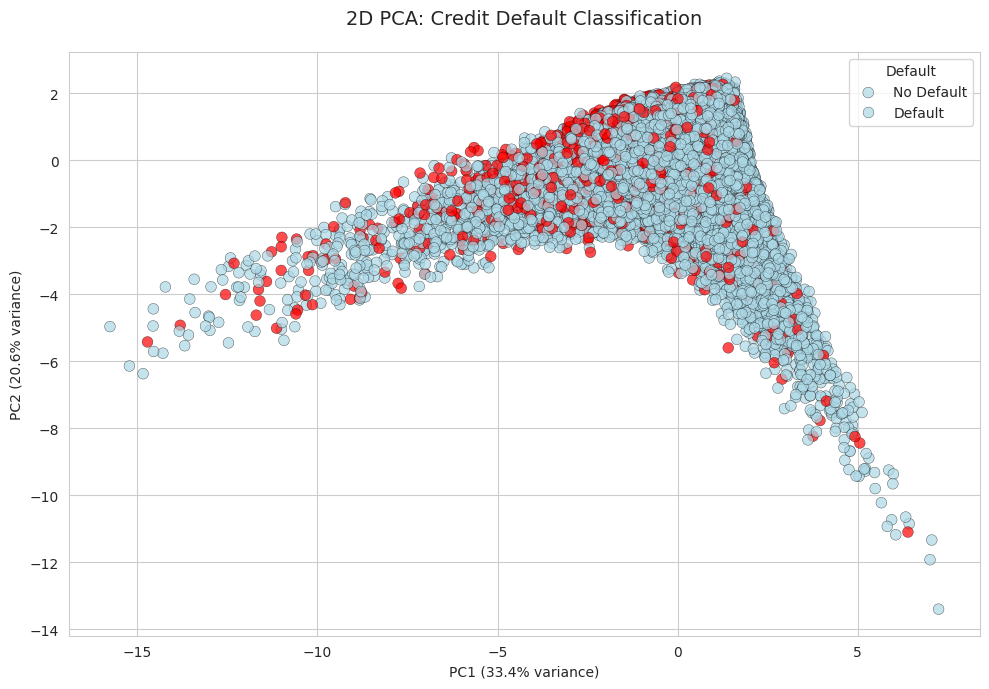

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Scatter plot
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Default',
    palette={0: 'lightblue', 1: 'red'},
    alpha=0.7,
    s=60,
    edgecolor='k',
    linewidth=0.3
)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('2D PCA: Credit Default Classification', fontsize=14, pad=20)
plt.legend(title='Default', labels=['No Default', 'Default'])

# Optional: Add density contours
# sns.kdeplot(data=pca_df[pca_df['Default']==1], x='PC1', y='PC2', levels=5, color="red", linewidths=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Conclusion: pour le momoent le SVM non linéaire classifier a les bons résultats entre les 3 modèle

## 2. Les modèles avec justement du poids de la classe

# Modèle non linéaire avec ajustement de poids

In [13]:
start_time=time.time()

c_svc_weighted = cuSVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    probability=False,
    class_weight='balanced'
)

c_svc_weighted.fit(X_train_gpu, y_train_gpu)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds on GPU!")



✓ Training completed in 34.25 seconds on GPU!



 EVALUATION RESULTS: RBF Kernel (Class Weighted)

Classification Report:
              precision    recall  f1-score   support

           0     0.9077    0.7551    0.8244     45139
           1     0.1824    0.4158    0.2535      5931

    accuracy                         0.7157     51070
   macro avg     0.5450    0.5854    0.5390     51070
weighted avg     0.8235    0.7157    0.7581     51070


ROC-AUC Score       : 0.6154
PR-AUC (Avg Precision) : 0.1881
Class 1 F1-Score    : 0.2535
Class 1 Recall      : 0.4158
Class 1 Precision   : 0.1824

Confusion Matrix:
[[34083 11056]
 [ 3465  2466]]


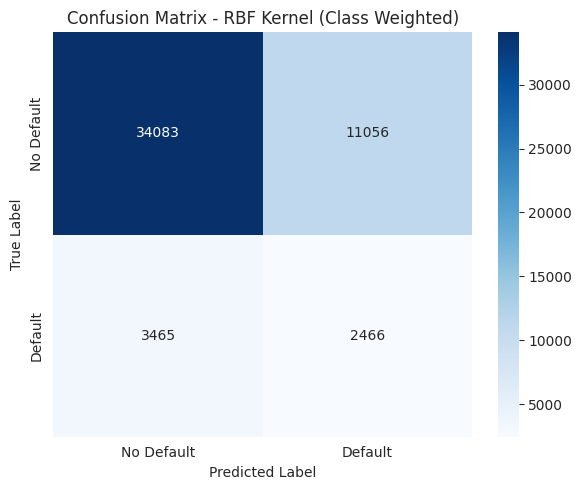

In [15]:
y_pred_weighted_gpu = c_svc_weighted.predict(X_test_gpu)
y_pred_weighted = cp.asnumpy(y_pred_weighted_gpu).astype('int64')

# ✅ 3. Get decision function → convert to probability-like score manually
decision_weighted = c_svc_weighted.decision_function(X_test_gpu)
decision_weighted_np = cp.asnumpy(decision_weighted)

# Apply sigmoid manually to map decision scores → [0, 1]
y_prob_weighted = 1 / (1 + np.exp(-decision_weighted_np))

# ✅ 4. Evaluate model
evaluate_model_final(
    y_true=y_test,               # or y_test_np if used earlier
    y_pred=y_pred_weighted,
    y_prob=y_prob_weighted,
    model_name="RBF Kernel (Class Weighted)"
)

## Modèle linéaire avec ajustement du poids de la classe

In [16]:
linear_svc_weighted_gpu = LinearSVC(
    C=1.0,
    class_weight='balanced',   # Supported!
    max_iter=1000,
    tol=1e-3
)

# Train (much faster than cuSVC)
linear_svc_weighted_gpu.fit(X_train_gpu, y_train_gpu)

# Predict labels
y_pred_linear_gpu = linear_svc_weighted_gpu.predict(X_test_gpu)
y_pred_linear_gpu = cp.asnumpy(y_pred_linear_gpu).astype('int64')

# Get decision function (on GPU)
decision_linear = linear_svc_weighted_gpu.decision_function(X_test_gpu)
decision_linear_np = cp.asnumpy(decision_linear)

# Convert to probability-like scores using sigmoid
y_prob_linear_gpu = 1 / (1 + np.exp(-decision_linear_np))


 EVALUATION RESULTS: Linear SVM (Class Weighted)

Classification Report:
              precision    recall  f1-score   support

           0     0.9177    0.6430    0.7562     45139
           1     0.1712    0.5613    0.2624      5931

    accuracy                         0.6335     51070
   macro avg     0.5445    0.6022    0.5093     51070
weighted avg     0.8310    0.6335    0.6988     51070


ROC-AUC Score       : 0.6429
PR-AUC (Avg Precision) : 0.2034
Class 1 F1-Score    : 0.2624
Class 1 Recall      : 0.5613
Class 1 Precision   : 0.1712

Confusion Matrix:
[[29025 16114]
 [ 2602  3329]]


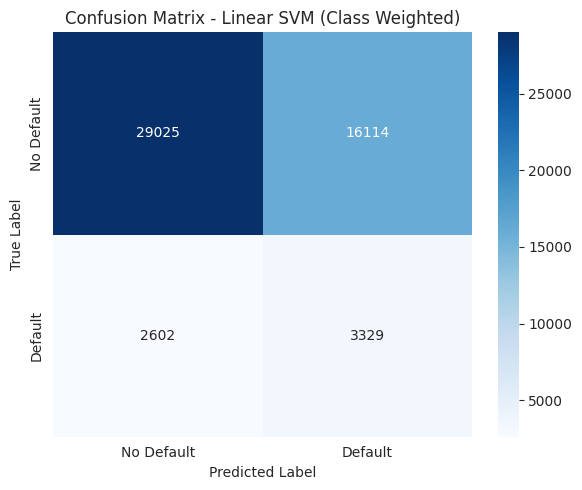

In [17]:
evaluate_model_final(
    y_true=y_test,
    y_pred=y_pred_linear_gpu,
    y_prob=y_prob_linear_gpu,
    model_name="Linear SVM (Class Weighted)"
)

# Modèle non linéaire avec SMOTE

In [18]:
X_train_cpu = X_train.copy()
y_train_cpu = y_train.copy()

print(f"Original train shape: {X_train_cpu.shape}")
print(f"Class distribution before SMOTE:\n{pd.Series(y_train_cpu).value_counts()}")

# --------------------------------------------------
# 2. Apply SMOTE
# --------------------------------------------------
smote = SMOTE(random_state=42)
X_res_cpu, y_res_cpu = smote.fit_resample(X_train_cpu, y_train_cpu)

print(f"\nAfter SMOTE:")
print(f"Resampled train shape: {X_res_cpu.shape}")
print(f"Class distribution after SMOTE:\n{pd.Series(y_res_cpu).value_counts()}")

# --------------------------------------------------
# 3. Move back to GPU
# --------------------------------------------------
X_res = cp.asarray(X_res_cpu)
y_res = cp.asarray(y_res_cpu)
X_test_gpu = cp.asarray(X_test)

Original train shape: (204277, 7)
Class distribution before SMOTE:
Default
0    180555
1     23722
Name: count, dtype: int64

After SMOTE:
Resampled train shape: (361110, 7)
Class distribution after SMOTE:
Default
0    180555
1    180555
Name: count, dtype: int64


In [19]:


# Use GPU-accelerated SVC from cuML
c_svc = cuSVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',     # ← This is allowed
    probability=True,
    random_state=42
)

# Fit the model on GPU
c_svc.fit(X_res, y_res)

training_time = time.time() - start_time
print(f"✓ Training completed in {training_time:.2f} seconds on GPU!")

# Evaluate the model


[2025-11-07 14:24:25.731] [CUML] [warning] Random state is currently ignored by probabilistic SVC
✓ Training completed in 501.98 seconds on GPU!


Test predictions shape: (51070,)
Probability range: [0.2574, 0.7820]

 EVALUATION RESULTS: cuSVC (SMOTE )

Classification Report:
              precision    recall  f1-score   support

           0     0.9095    0.6850    0.7814     45139
           1     0.1671    0.4810    0.2480      5931

    accuracy                         0.6613     51070
   macro avg     0.5383    0.5830    0.5147     51070
weighted avg     0.8232    0.6613    0.7195     51070


ROC-AUC Score       : 0.6160
PR-AUC (Avg Precision) : 0.1883
Class 1 F1-Score    : 0.2480
Class 1 Recall      : 0.4810
Class 1 Precision   : 0.1671

Confusion Matrix:
[[30918 14221]
 [ 3078  2853]]


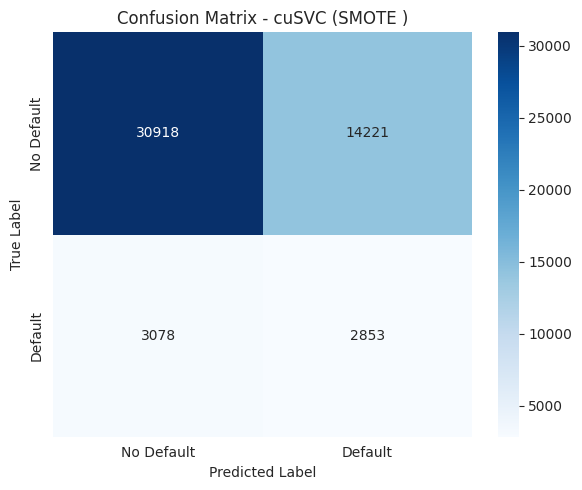

In [20]:
y_pred_gpu_smote = c_svc.predict(X_test_gpu)
y_pred_smote = cp.asnumpy(y_pred_gpu_smote).astype('int64')

# Manual probability via decision function + sigmoid
decision_smote = c_svc.decision_function(X_test_gpu)
decision_np_smote = cp.asnumpy(decision_smote)
y_prob_smote = 1 / (1 + np.exp(-decision_np_smote))

# Keep test labels as numpy
y_test_np = y_test.copy()

print(f"Test predictions shape: {y_pred_smote.shape}")
print(f"Probability range: [{y_prob_smote.min():.4f}, {y_prob_smote.max():.4f}]")
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_smote,
    y_prob=y_prob_smote,
    model_name="cuSVC (SMOTE )"
)

# Modèle linéaire avec SMOTE

In [21]:
start_time = time.time()

linear_svc_gpu = LinearSVC(
    C=1.0,
    # class_weight='balanced'  # <-- NOT needed if you used SMOTE
    max_iter=2000,
    tol=1e-4,
    verbose=False
)

linear_svc_gpu.fit(X_res, y_res)

train_time = time.time() - start_time
print(f"LinearSVC training completed in {train_time:.3f}s on GPU!")

LinearSVC training completed in 0.141s on GPU!


In [22]:
# Convert test data to GPU
X_test_gpu = cp.asarray(X_test)

# Predict labels
y_pred_linear_gpu = linear_svc_gpu.predict(X_test_gpu)
y_pred_linear = cp.asnumpy(y_pred_linear_gpu).astype('int64')

# Decision function → pseudo-probabilities
decision_linear = linear_svc_gpu.decision_function(X_test_gpu)
decision_linear_np = cp.asnumpy(decision_linear)
y_prob_linear = 1 / (1 + np.exp(-decision_linear_np))  # sigmoid for probability-like values

# Test labels as numpy
y_test_np = y_test.copy()

print(f"Test predictions shape: {y_pred_linear.shape}")
print(f"Probability range: [{y_prob_linear.min():.4f}, {y_prob_linear.max():.4f}]")


Test predictions shape: (51070,)
Probability range: [0.3658, 0.9043]



 EVALUATION RESULTS: Linear SVM (Class Weighted)

Classification Report:
              precision    recall  f1-score   support

           0     0.9178    0.6277    0.7455     45139
           1     0.1679    0.5719    0.2596      5931

    accuracy                         0.6212     51070
   macro avg     0.5428    0.5998    0.5026     51070
weighted avg     0.8307    0.6212    0.6891     51070


ROC-AUC Score       : 0.6384
PR-AUC (Avg Precision) : 0.1938
Class 1 F1-Score    : 0.2596
Class 1 Recall      : 0.5719
Class 1 Precision   : 0.1679

Confusion Matrix:
[[28333 16806]
 [ 2539  3392]]


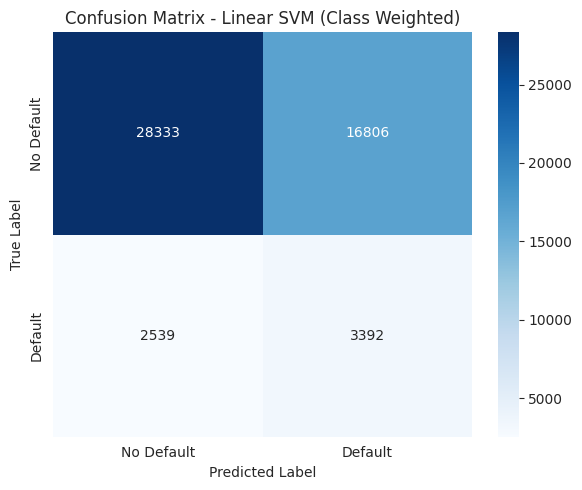

In [23]:
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_linear,
    y_prob=y_prob_linear,
    model_name="Linear SVM (Class Weighted)"
)


# Modèles avec sous-échantillonage

1. Modèle linéaire SVM avec sous-échantillonage


In [25]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_res_under, y_res_under = rus.fit_resample(X_train, y_train)

print("Before Under-sampling:", y_train.value_counts(normalize=True) * 100)
print("After Under-sampling:", pd.Series(y_res_under).value_counts(normalize=True) * 100)

# Convert to GPU
X_res_under_gpu = cp.asarray(X_res_under, dtype='float64')
y_res_under_gpu = cp.asarray(y_res_under, dtype='int64')

Before Under-sampling: Default
0    88.387337
1    11.612663
Name: proportion, dtype: float64
After Under-sampling: Default
0    50.0
1    50.0
Name: proportion, dtype: float64


In [26]:
import time
from cuml.svm import SVC as cuSVC

start_time = time.time()

linear_svc_under = LinearSVC(
    C=1.0,
    max_iter=2000,        # Increase if convergence warning appears
    tol=1e-4,
    class_weight=None     # Correct: data is already balanced via undersampling
)

linear_svc_under.fit(X_res_under_gpu, y_res_under_gpu)

training_time = time.time() - start_time
print(f"Linear SVM trained in {training_time:.3f} seconds on GPU!")

Linear SVM trained in 0.072 seconds on GPU!


In [27]:
# Prediction
y_pred_linear_gpu = linear_svc_under.predict(X_test_gpu)
y_pred_linear = cp.asnumpy(y_pred_linear_gpu)

# Convert decision_function → probability-like score
decision_linear = linear_svc_under.decision_function(X_test_gpu)
decision_linear_np = cp.asnumpy(decision_linear)
y_prob_linear = 1 / (1 + np.exp(-decision_linear_np))  # Sigmoid



 EVALUATION RESULTS: Linear SVM (Under-sampled)

Classification Report:
              precision    recall  f1-score   support

           0     0.9181    0.6287    0.7463     45139
           1     0.1687    0.5734    0.2607      5931

    accuracy                         0.6223     51070
   macro avg     0.5434    0.6011    0.5035     51070
weighted avg     0.8311    0.6223    0.6899     51070


ROC-AUC Score       : 0.6398
PR-AUC (Avg Precision) : 0.1934
Class 1 F1-Score    : 0.2607
Class 1 Recall      : 0.5734
Class 1 Precision   : 0.1687

Confusion Matrix:
[[28378 16761]
 [ 2530  3401]]


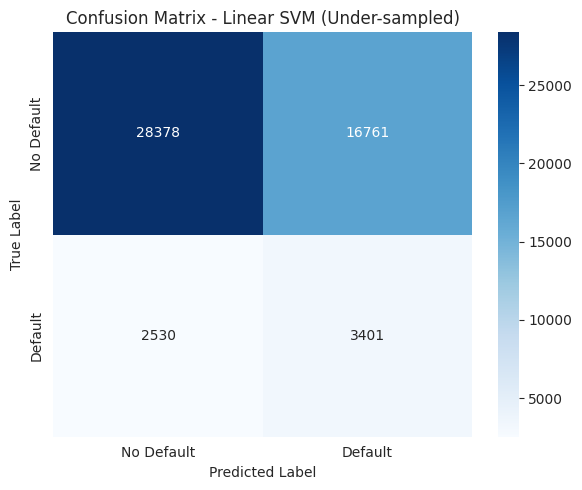

In [28]:
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_linear,
    y_prob=y_prob_linear,
    model_name="Linear SVM (Under-sampled)"
)


2. Modèle SVM non linéaire avec sous-échantillonage

In [29]:
# RBF SVM
start_time = time.time()
rbf_svc_under = cuSVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    probability=False,  # Manual probability from decision function
    class_weight=None
)

rbf_svc_under.fit(X_res_under_gpu, y_res_under_gpu)
print(f"✓ RBF SVM trained in {time.time() - start_time:.2f} seconds")


✓ RBF SVM trained in 2.74 seconds



 EVALUATION RESULTS: RBF SVM (Under-sampled)

Classification Report:
              precision    recall  f1-score   support

           0     0.9079    0.7511    0.8221     45139
           1     0.1815    0.4202    0.2535      5931

    accuracy                         0.7126     51070
   macro avg     0.5447    0.5856    0.5378     51070
weighted avg     0.8235    0.7126    0.7560     51070


ROC-AUC Score       : 0.6133
PR-AUC (Avg Precision) : 0.1932
Class 1 F1-Score    : 0.2535
Class 1 Recall      : 0.4202
Class 1 Precision   : 0.1815

Confusion Matrix:
[[33902 11237]
 [ 3439  2492]]


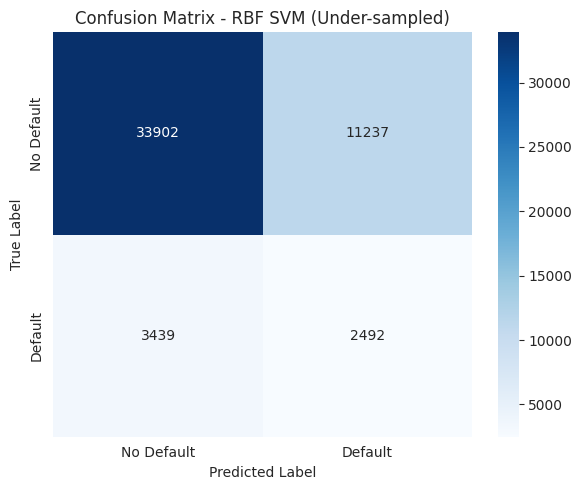

In [30]:
# Prediction
y_pred_rbf_gpu = rbf_svc_under.predict(X_test_gpu)
y_pred_rbf = cp.asnumpy(y_pred_rbf_gpu)

# Decision function → probability-like values
decision_rbf = rbf_svc_under.decision_function(X_test_gpu)
decision_rbf_np = cp.asnumpy(decision_rbf)
y_prob_rbf = 1 / (1 + np.exp(-decision_rbf_np))

# Evaluation
evaluate_model_final(
    y_true=y_test_np,
    y_pred=y_pred_rbf,
    y_prob=y_prob_rbf,
    model_name="RBF SVM (Under-sampled)"
)


# Model Comparison and Best Model Selection

In [32]:
# Store all model results for comparison (F1-Score and Recall only)
models_comparison = []

# Helper function to safely convert to numpy
def to_numpy(arr):
    if hasattr(arr, '__cuda_array_interface__'):
        return arr.get()
    # If it's already a numpy array or pandas series, convert to numpy
    elif hasattr(arr, 'to_numpy'):
        return arr.to_numpy()
    elif hasattr(arr, 'values'):
        return arr.values
    return arr

def add_model_metrics(model_name, model_obj, y_true, y_pred):
    y_true_safe = to_numpy(y_true)
    y_pred_safe = to_numpy(y_pred)
    report = classification_report(y_true_safe, y_pred_safe, digits=4, output_dict=True)
    models_comparison.append({
        'Model Name': model_name,
        'Model Object': model_obj,
        'F1-Score (Class 1)': report['1']['f1-score'],
        'Recall (Class 1)': report['1']['recall']
    })

# Model 1: C-SVC (RBF, No Balancing)
add_model_metrics('C-SVC (RBF, No Balancing)', c_svc, y_test_np, y_pred)

# Model 2: Linear SVM (No Balancing)
add_model_metrics('Linear SVM (No Balancing)', linear_svm, y_test_np_2, y_pred_2)



# Model 4: RBF with class weights
add_model_metrics('RBF SVM (Class Weighted)', c_svc_weighted, y_test, y_pred_weighted)

# Model 5: Linear SVM with class weights
add_model_metrics('Linear SVM (Class Weighted)', linear_svc_weighted_gpu, y_test, y_pred_linear_gpu)

# Model 6: RBF with SMOTE
add_model_metrics('RBF SVM (SMOTE)', c_svc, y_test_np, y_pred_smote)

# Model 7: Linear SVM with SMOTE
add_model_metrics('Linear SVM (SMOTE)', linear_svc_gpu, y_test_np, y_pred_linear)

# Model 8: Linear SVM with under-sampling
add_model_metrics('Linear SVM (Under-sampled)', linear_svc_under, y_test_np, y_pred_linear)

# Model 9: RBF SVM with under-sampling
add_model_metrics('RBF SVM (Under-sampled)', rbf_svc_under, y_test_np, y_pred_rbf)

# Create comparison DataFrame
comparison_df = pd.DataFrame(models_comparison).drop('Model Object', axis=1)

print("="*60)
print(" MODEL COMPARISON: F1-SCORE & RECALL (Class 1)")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

 MODEL COMPARISON: F1-SCORE & RECALL (Class 1)
                 Model Name  F1-Score (Class 1)  Recall (Class 1)
  C-SVC (RBF, No Balancing)            0.000000          0.000000
  Linear SVM (No Balancing)            0.000000          0.000000
   RBF SVM (Class Weighted)            0.253534          0.415781
Linear SVM (Class Weighted)            0.260683          0.573428
            RBF SVM (SMOTE)            0.248033          0.481032
         Linear SVM (SMOTE)            0.260683          0.573428
 Linear SVM (Under-sampled)            0.260683          0.573428
    RBF SVM (Under-sampled)            0.253510          0.420165


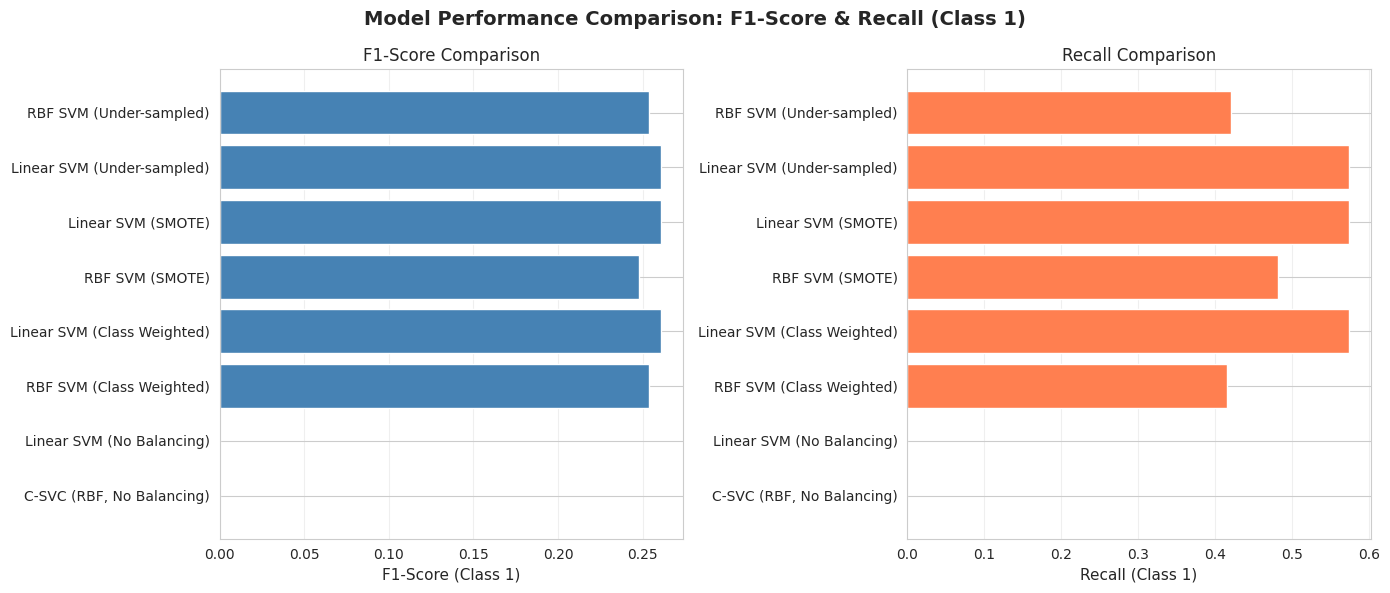

In [33]:
# Visualize F1-Score and Recall comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Model Performance Comparison: F1-Score & Recall (Class 1)', fontsize=14, fontweight='bold')

model_names = [model['Model Name'] for model in models_comparison]

# Plot 1: F1-Score
axes[0].barh(model_names, [model['F1-Score (Class 1)'] for model in models_comparison], color='steelblue')
axes[0].set_xlabel('F1-Score (Class 1)', fontsize=11)
axes[0].set_title('F1-Score Comparison', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Recall
axes[1].barh(model_names, [model['Recall (Class 1)'] for model in models_comparison], color='coral')
axes[1].set_xlabel('Recall (Class 1)', fontsize=11)
axes[1].set_title('Recall Comparison', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
# Select best model based on F1-Score and Recall
print("\n" + "="*60)
print(" BEST MODEL SELECTION")
print("="*60)

# Calculate composite score (50% F1-Score, 50% Recall)
for model in models_comparison:
    model['Composite Score'] = (model['F1-Score (Class 1)'] * 0.5 +
                                 model['Recall (Class 1)'] * 0.5)

# Find best model
best_model_idx = max(range(len(models_comparison)), key=lambda i: models_comparison[i]['Composite Score'])
best_model = models_comparison[best_model_idx]

# Display ranked models
comparison_ranked = pd.DataFrame(models_comparison).drop('Model Object', axis=1)
comparison_ranked = comparison_ranked.sort_values('Composite Score', ascending=False)

print("\n" + "="*60)
print(" ALL MODELS RANKED BY COMPOSITE SCORE")
print("="*60)
print(comparison_ranked.to_string(index=False))
print("="*60)

print("\n" + "="*60)
print(" BEST MODEL")
print("="*60)
print(f"Model Name:          {best_model['Model Name']}")
print(f"Composite Score:     {best_model['Composite Score']:.4f}")
print(f"F1-Score (Class 1):  {best_model['F1-Score (Class 1)']:.4f}")
print(f"Recall (Class 1):    {best_model['Recall (Class 1)']:.4f}")
print("="*60)


 BEST MODEL SELECTION

 ALL MODELS RANKED BY COMPOSITE SCORE
                 Model Name  F1-Score (Class 1)  Recall (Class 1)  Composite Score
Linear SVM (Class Weighted)            0.260683          0.573428         0.417055
         Linear SVM (SMOTE)            0.260683          0.573428         0.417055
 Linear SVM (Under-sampled)            0.260683          0.573428         0.417055
            RBF SVM (SMOTE)            0.248033          0.481032         0.364532
    RBF SVM (Under-sampled)            0.253510          0.420165         0.336837
   RBF SVM (Class Weighted)            0.253534          0.415781         0.334658
  C-SVC (RBF, No Balancing)            0.000000          0.000000         0.000000
  Linear SVM (No Balancing)            0.000000          0.000000         0.000000

 BEST MODEL
Model Name:          Linear SVM (Class Weighted)
Composite Score:     0.4171
F1-Score (Class 1):  0.2607
Recall (Class 1):    0.5734


In [35]:
# Save the best model - Modified for Colab
import pickle
import os

# Create Models directory in current location (/content/)
models_dir = './Models'
os.makedirs(models_dir, exist_ok=True)

# Save the best model
best_model_object = best_model['Model Object']
best_model_name = best_model['Model Name'].replace(' ', '_').replace('(', '').replace(')', '').replace('=', '')
model_filename = f'{models_dir}/best_svm_model_{best_model_name}.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(best_model_object, f)

# Save metadata and summary (same as before)
metadata = {
    'model_name': best_model['Model Name'],
    'composite_score': best_model['Composite Score'],
    'f1_score': best_model['F1-Score (Class 1)'],
    'recall': best_model['Recall (Class 1)'],
    'saved_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

metadata_filename = f'{models_dir}/best_svm_model_metadata.pkl'
with open(metadata_filename, 'wb') as f:
    pickle.dump(metadata, f)

# Save summary report
summary_filename = f'{models_dir}/model_comparison_summary.txt'
with open(summary_filename, 'w', encoding='utf-8') as f:
    f.write("="*60 + "\n")
    f.write(" SVM MODELS COMPARISON (F1-Score & Recall)\n")
    f.write("="*60 + "\n\n")
    f.write(comparison_ranked.to_string(index=False))
    f.write("\n\n" + "="*60 + "\n")
    f.write(" BEST MODEL\n")
    f.write("="*60 + "\n")
    f.write(f"Model Name:          {best_model['Model Name']}\n")
    f.write(f"Composite Score:     {best_model['Composite Score']:.4f}\n")
    f.write(f"F1-Score (Class 1):  {best_model['F1-Score (Class 1)']:.4f}\n")
    f.write(f"Recall (Class 1):    {best_model['Recall (Class 1)']:.4f}\n")
    f.write(f"Saved Date:          {metadata['saved_date']}\n")
    f.write("="*60 + "\n")

print("\n" + "="*60)
print(" FILES SAVED SUCCESSFULLY")
print("="*60)
print(f"Model:    {model_filename}")
print(f"Metadata: {metadata_filename}")
print(f"Summary:  {summary_filename}")
print("="*60)

# Show where files are actually saved
print(f"\nAbsolute paths:")
print(f"Models directory: {os.path.abspath(models_dir)}")


 FILES SAVED SUCCESSFULLY
Model:    ./Models/best_svm_model_Linear_SVM_Class_Weighted.pkl
Metadata: ./Models/best_svm_model_metadata.pkl
Summary:  ./Models/model_comparison_summary.txt

Absolute paths:
Models directory: /content/Models


In [36]:
from google.colab import files

# Download all model files
files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
best_model = models_comparison[best_model_idx]
gpu_model = best_model['Model Object']